# 07 - Tree Hyperparameters

In [11]:
from setup import * #gets the real data

In [12]:
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, dummy, preprocessing
import xgboost as xgb
import dtreeviz
from yellowbrick.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
#also, must install graphviz for plotting to work with xgb

In [13]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1) #this is the scikit-learn tree
X_train = kag_pl.fit_transform(kag_X_train)
stump_dt.fit(X_train, kag_y_train)

/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:80: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call 

DecisionTreeClassifier(max_depth=1)

In [14]:
stump_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

## Tracking Changes with Validation Curves

- We will measure how OOS error varies with tree depth

Text(0.5, 0, 'max_depth')

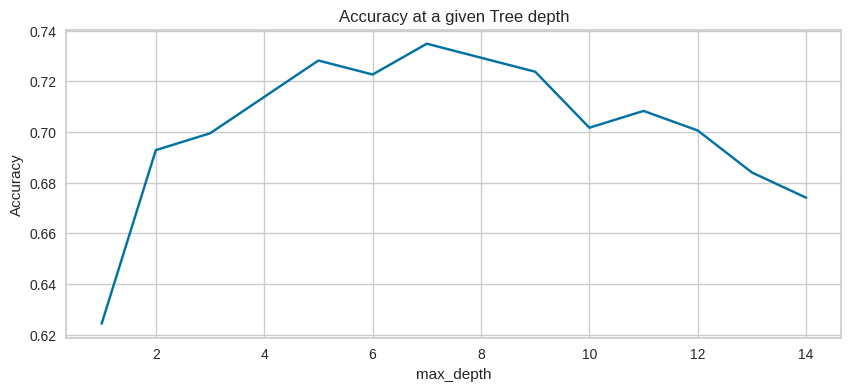

In [15]:
accuracies = []
for depth in range(1, 15):
    between = tree.DecisionTreeClassifier(max_depth=depth)
    between.fit(X_train, kag_y_train)
    accuracies.append(between.score(X_test, kag_y_test))
fig, ax = plt.subplots(figsize=(10,4))
(pd.Series(accuracies, name='Accuracy',index=range(1, len(accuracies)+1))
 .plot(ax=ax, title='Accuracy at a given Tree depth'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('max_depth')

In [16]:
between = tree.DecisionTreeClassifier(max_depth=7)
between.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=7)

In [17]:
between.score(X_test, kag_y_test) #recall the stump had accuracy 62% and the overfithad accuracy of 68%. So, this is nice!

0.7337016574585635

## Leveraging Yellowbrick

In [19]:
params = {
    'max_depth': [3,5,7,8],
    'min_samples_leaf': [1,3,4,5,6],
    'min_samples_split': [2,3,4,5,6]
}
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(),
                           param_grid=params, cv=4, n_jobs=-1,
                           verbose=1, scoring='accuracy')
#again, fitting it on all the data, but with cross validation instead of a hold out set.
#usually, we wouldn't add the holdout set back in here
grid_search.fit(pd.concat([X_train, X_test]),pd.concat([kag_y_train, kag_y_test]))

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=1)

In [20]:
grid_search.best_params_ #note that best_params_ has an underscore, because this attribute is determined by fit()

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [22]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [23]:
grid_search.cv_results_['mean_test_score'].__len__() #so, 100 candidates. this is the mean (OOS) score across the 4 cv folds.

100

In [25]:
between2 = tree.DecisionTreeClassifier(**grid_search.best_params_) # passing in best params with kwargs

In [26]:
between2.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)

In [36]:
X_train.dtypes

age                              int64
education                      float64
years_exp                      float64
compensation                     int64
python                           int64
r                                int64
sql                              int64
Q1_Male                          int64
Q1_Female                        int64
Q1_Prefer not to say             int64
Q1_Prefer to self-describe       int64
Q3_United States of America      int64
Q3_India                         int64
Q3_China                         int64
major_cs                         int64
major_other                      int64
major_eng                        int64
major_stat                       int64
dtype: object

In [37]:
between2.score(X_test, kag_y_test) # the optimized model has a 72.6% accuracy. Vs the 62-

0.7259668508287292

In [41]:
(pd.DataFrame(grid_search.cv_results_)
 .sort_values(by='rank_test_score')
 .style
 .background_gradient(axis='rows')
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
66,0.011754,0.000542,0.004403,0.000102,7,5,3,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3}",0.706897,0.740053,0.706897,0.719788,0.718408,0.013559,1
65,0.011663,0.000936,0.004444,0.000298,7,5,2,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}",0.706897,0.737401,0.709549,0.719788,0.718408,0.011975,1
67,0.013257,0.003905,0.005179,0.000928,7,5,4,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 4}",0.708223,0.740053,0.709549,0.715803,0.718407,0.012821,3
69,0.012141,0.001008,0.006821,0.000824,7,5,6,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}",0.706897,0.740053,0.709549,0.715803,0.718076,0.013094,4
74,0.014470,0.001409,0.006543,0.003985,7,6,6,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 6}",0.708223,0.738727,0.705570,0.715803,0.717081,0.013049,5
68,0.012000,0.002564,0.006725,0.001085,7,5,5,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}",0.706897,0.737401,0.706897,0.715803,0.716749,0.012465,6
70,0.013299,0.004629,0.006034,0.000806,7,6,2,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.705570,0.738727,0.705570,0.715803,0.716418,0.013541,7
73,0.016272,0.004690,0.004920,0.000568,7,6,5,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 5}",0.701592,0.738727,0.705570,0.715803,0.715423,0.014419,8
72,0.013531,0.003361,0.006781,0.001842,7,6,4,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 4}",0.701592,0.738727,0.705570,0.715803,0.715423,0.014419,8
71,0.011689,0.001587,0.005273,0.000577,7,6,3,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 3}",0.701592,0.738727,0.705570,0.715803,0.715423,0.014419,8


In [42]:
# we can manually run cross_validation if we want
results = model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=7),
    X=pd.concat([X_train, X_test], axis='index'),
    y=pd.concat([kag_y_train,kag_y_test],axis='index'),
    cv=4 
)

In [43]:
results #here are the cross validation scores on the 4 folds

array([0.69761273, 0.73607427, 0.70159151, 0.71447543])

In [44]:
results.mean()

0.7124384865489413

In [46]:
#help(tree.DecisionTreeClassifier) # default is min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None
# min_samples_split is how many samples have to be in a node to split it
# min_samples_leaf is how many samples need to end up in each leaf to split it
# so, if min_samples_split < min_samples_leaf, the min_samples_split won't be binding!
# essentially, min_samples_leaf says how even the split must be. So, if you had 100 samples in a node
# but the split was 99 and 1, min_samples_split = 2 would still allow it but min_samples_leaf=2 would not

In [47]:
# repeating angainst updated hyperparameters from the grid search
results = model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=2), #default is min_samples_leaf=1, min_samples_split=2
    X=pd.concat([X_train, X_test],axis='index'),
    y = pd.concat([kag_y_train, kag_y_test],axis='index')
)

In [48]:
results

array([0.72636816, 0.70480929, 0.71973466, 0.70315091, 0.72636816])

In [49]:
results.mean()

0.7160862354892206